In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
batting = pyb.lahman.batting()
pitching = pyb.lahman.pitching()
pitching_id = np.array(pitching['playerID'])

In [3]:
batting = batting[batting['AB']>0]
batting = batting[~batting['playerID'].isin(pitching_id)]

In [4]:
career = batting.groupby('playerID').agg({'H': 'sum', 'AB': 'sum'}).reset_index()
career['average'] = career['H']/career['AB']

In [5]:
master = pyb.lahman.master()
master['name'] = master['nameFirst']+' '+master['nameLast']
master_name = master[['playerID', 'name']]

In [6]:
career = pd.merge(master_name, career, on='playerID')

In [7]:
career.sort_values(by='average').head(5)

,playerID,name,H,AB,average
7404,rextewi01,William Rexter,0,4,0.0
7939,schinbi01,Bill Schindler,0,2,0.0
9689,womacsi01,Sid Womack,0,3,0.0
8435,spearna01,Nate Spears,0,8,0.0
3355,gorneni01,Nick Gorneault,0,4,0.0


In [8]:
career.sort_values(by='average', ascending=False).head(5)

,playerID,name,H,AB,average
7023,pickuty01,Ty Pickup,1,1,1.0
3021,gallaja01,Jackie Gallagher,1,1,1.0
712,birasst01,Steve Biras,2,2,1.0
380,banisje01,Jeff Banister,1,1,1.0
6957,peterbi01,Bill Peterman,1,1,1.0


# Estimate Prior

In [9]:
ab_500 = career[career['AB']>=500]

In [10]:
mu = ab_500['average'].mean()
var = ab_500['average'].var()

In [11]:
def estBetaParams(mu, var):
    alpha = ((1 - mu) / var - 1 / mu) * (mu ** 2)
    beta = alpha * (1 / mu - 1)
    
    return {"alpha": alpha, "beta": beta}
estBetaParams(mu, var)

{'alpha': 79.72754095652378, 'beta': 228.85067605081935}

In [12]:
alpha0 = estBetaParams(mu, var)['alpha']
beta0 = estBetaParams(mu, var)['beta']

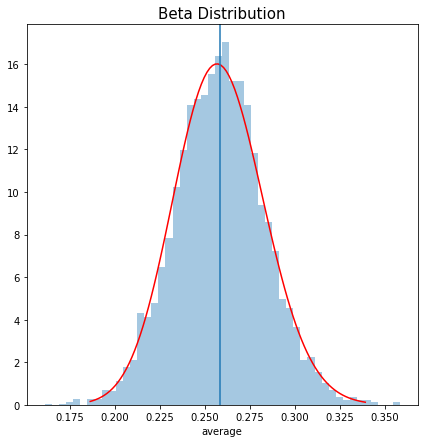

In [13]:
a = alpha0
b = beta0

x = np.linspace(sp.stats.beta.ppf(0.001, a, b),sp.stats.beta.ppf(0.999, a, b), 100)

fig, ax = plt.subplots(figsize=(7,7))
ax = sns.distplot(ab_500['average'], kde=False, norm_hist=True)
ax.plot(x, sp.stats.beta.pdf(x, a, b), 'r-')
plt.title('Beta Distribution', fontsize='15')
plt.axvline(mu)
plt.show()

In [14]:
career['estimate'] = (career['H']+alpha0) / (career['AB']+alpha0+beta0)

In [15]:
career.sort_values(by='estimate').head(10)

,playerID,name,H,AB,average,estimate
631,bergebi01,Bill Bergen,516,3028,0.170410,0.178544
6743,oylerra01,Ray Oyler,221,1265,0.174704,0.191111
9242,vukovjo01,John Vukovich,90,559,0.161002,0.195634
4202,humphjo01,John Humphries,52,364,0.142857,0.195855
351,bakerge01,George Baker,74,474,0.156118,0.196437
2529,eastehe01,Henry Easterday,203,1129,0.179805,0.196669
3239,gladmbu01,Buck Gladmon,56,380,0.147368,0.197113
248,armbrch01,Charlie Armbruster,53,355,0.149296,0.200018
8998,traffbi01,Bill Traffley,116,663,0.174962,0.201453
7775,ryanmi02,Mike Ryan,370,1920,0.192708,0.201800


In [16]:
career.sort_values(by='estimate', ascending=False).head(10)

,playerID,name,H,AB,average,estimate
4106,hornsro01,Rogers Hornsby,2930,8173,0.358497,0.354855
4296,jacksjo01,Shoeless Joe Jackson,1772,4981,0.355752,0.350071
2202,delahed01,Ed Delahanty,2597,7510,0.345806,0.342355
3619,hamilbi01,Billy Hamilton,2164,6283,0.344421,0.340393
3818,heilmha01,Harry Heilmann,2660,7787,0.341595,0.338423
4599,keelewi01,Willie Keeler,2932,8591,0.341287,0.338412
8844,terrybi01,Bill Terry,2193,6428,0.341164,0.337371
3130,gehrilo01,Lou Gehrig,2721,8001,0.340082,0.337048
4915,lajoina01,Nap Lajoie,3243,9590,0.338165,0.335677
3547,gwynnto01,Tony Gwynn,3141,9288,0.338178,0.335612


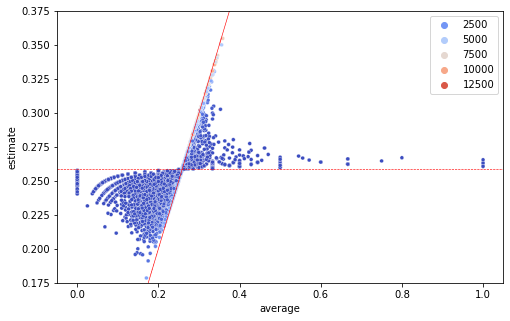

In [43]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=career, x='average', y='estimate', hue='AB', palette='coolwarm', s=15)
sns.lineplot(data=career, x='average', y='average', color='red', linewidth=0.6)
plt.axhline(mu, color='red', linestyle='--', linewidth=0.6)
plt.xlim(-0.05,1.05)
plt.ylim(0.175,0.375)
plt.show()

# Posterior distribution

In [18]:
career['alpha1'] = alpha0 + career['H']
career['beta1'] = beta0 + career['AB'] - career['H']

In [19]:
career

,playerID,name,H,AB,average,estimate,alpha1,beta1
0,aaronha01,Hank Aaron,3771,12364,0.304998,0.303863,3850.727541,8821.850676
1,aaronto01,Tommie Aaron,216,944,0.228814,0.236095,295.727541,956.850676
2,abadan01,Andy Abad,2,21,0.095238,0.247976,81.727541,247.850676
3,abadijo01,John Abadie,11,49,0.224490,0.253728,90.727541,266.850676
4,abbated01,Ed Abbaticchio,772,3044,0.253614,0.254052,851.727541,2500.850676
...,...,...,...,...,...,...,...,...
9857,zuninmi01,Mike Zunino,518,2559,0.202423,0.208443,597.727541,2269.850676
9858,zupcibo01,Bob Zupcic,199,795,0.250314,0.252567,278.727541,824.850676
9859,zupofr01,Frank Zupo,3,18,0.166667,0.253316,82.727541,243.850676
9860,zuvelpa01,Paul Zuvella,109,491,0.221996,0.236034,188.727541,610.850676


In [20]:
tor = batting[(batting['yearID']==2021)&(batting['teamID']=='TOR')&(batting['G']>100)]
tor_100 = np.array(tor['playerID'])

tor_bat = career[career['playerID'].isin(tor_100)]
tor_bat

,playerID,name,H,AB,average,estimate,alpha1,beta1
696,bichebo01,Bo Bichette,289,959,0.301356,0.290891,368.727541,898.850676
3454,grichra01,Randal Grichuk,743,3028,0.245376,0.246578,822.727541,2513.850676
3508,guerrvl02,Vladimir Guerrero,372,1289,0.288596,0.282758,451.727541,1145.850676
3528,gurrilo01,Lourdes Gurriel,359,1271,0.282455,0.277750,438.727541,1140.850676
3902,hernate01,Teoscar Hernandez,474,1821,0.260297,0.260017,553.727541,1575.850676
8040,semiema01,Marcus Semien,1003,3918,0.255998,0.256171,1082.727541,3143.850676


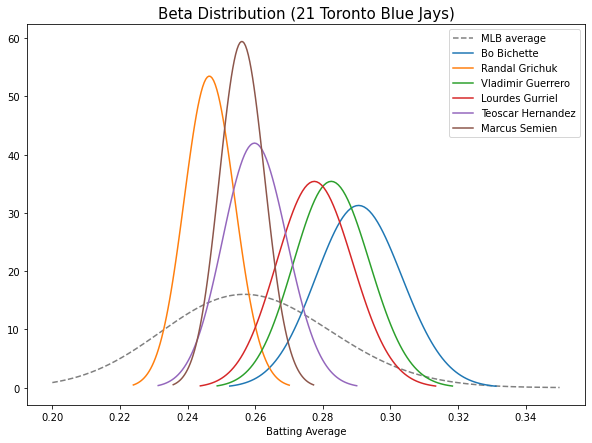

In [36]:
fig, ax = plt.subplots(figsize=(10,7))
x = np.linspace(0.2, 0.35, 1000)
ax.plot(x, sp.stats.beta.pdf(x, alpha0, beta0), color='grey', linestyle='--', label='MLB average')
for i in range(len(tor_bat)):
    a = tor_bat['alpha1'].iloc[i]
    b = tor_bat['beta1'].iloc[i]

    x = np.linspace(sp.stats.beta.ppf(0.001, a, b), sp.stats.beta.ppf(0.999, a, b), 100)
    ax.plot(x, sp.stats.beta.pdf(x, a, b), label=tor_bat['name'].iloc[i])

plt.title('Beta Distribution (21 Toronto Blue Jays)', fontsize='15')
plt.xlabel('Batting Average')
plt.legend()
plt.show()

# Credible Interval

In [24]:
tor_bat['low'] = sp.stats.beta.ppf(0.025, tor_bat['alpha1'], tor_bat['beta1'])
tor_bat['high'] = sp.stats.beta.ppf(0.975, tor_bat['alpha1'], tor_bat['beta1'])
tor_bat

,playerID,name,H,AB,average,estimate,alpha1,beta1,low,high
696,bichebo01,Bo Bichette,289,959,0.301356,0.290891,368.727541,898.850676,0.266217,0.316191
3454,grichra01,Randal Grichuk,743,3028,0.245376,0.246578,822.727541,2513.850676,0.232101,0.261343
3508,guerrvl02,Vladimir Guerrero,372,1289,0.288596,0.282758,451.727541,1145.850676,0.260943,0.305087
3528,gurrilo01,Lourdes Gurriel,359,1271,0.282455,0.277750,438.727541,1140.850676,0.255940,0.300093
3902,hernate01,Teoscar Hernandez,474,1821,0.260297,0.260017,553.727541,1575.850676,0.241608,0.278854
8040,semiema01,Marcus Semien,1003,3918,0.255998,0.256171,1082.727541,3143.850676,0.243123,0.269438


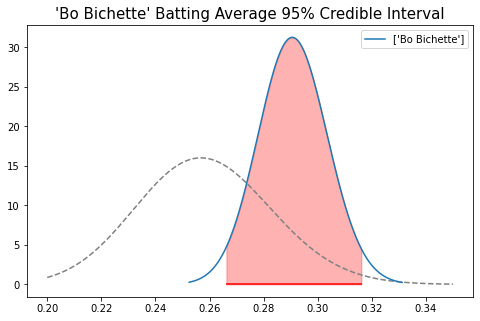

In [60]:
bo = tor_bat[tor_bat['playerID']=='bichebo01']

fig, ax = plt.subplots(figsize=(8,5))

x = np.linspace(0.2, 0.35, 10000)
ax.plot(x, sp.stats.beta.pdf(x, alpha0, beta0), color='grey', linestyle='--')

x_bo = np.linspace(sp.stats.beta.ppf(0.001, bo['alpha1'], bo['beta1']), sp.stats.beta.ppf(0.999, bo['alpha1'], bo['beta1']), 10000)
ax.plot(x_bo, sp.stats.beta.pdf(x_bo, bo['alpha1'], bo['beta1']), label=bo['name'].values)

x_range=np.arange(bo['low'].values, bo['high'].values, 0.0001)
plt.fill_between(x_range,sp.stats.beta.pdf(x_range, bo['alpha1'], bo['beta1']),color='red', alpha=0.3)
ax.hlines(y=0, xmin=bo['low'], xmax=bo['high'],  color='red')
plt.legend()
plt.title("'Bo Bichette' Batting Average 95% Credible Interval", fontsize='15')
plt.show()

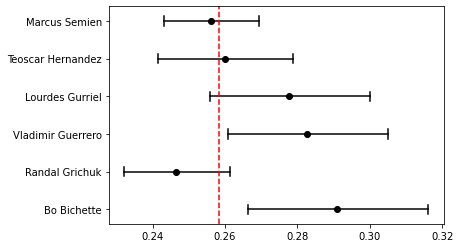

In [26]:
vertical_line_width=0.25

for lower,upper,mean,y in zip(tor_bat['low'],tor_bat['high'],tor_bat['estimate'],range(len(tor_bat))):
    top = y - vertical_line_width / 2
    bottom = y + vertical_line_width / 2
    left = lower
    right = upper
    plt.plot([left, right], [y, y], color='black')
    plt.plot([left, left], [bottom, top], color='black')
    plt.plot([right, right], [bottom, top], color='black')
    plt.plot(mean, y,'o', color='black')
    
plt.yticks(range(len(tor_bat)),list(tor_bat['name']))
plt.axvline(mu, color='red', linestyle='--')
plt.show()

In [27]:
career['low'] = sp.stats.beta.ppf(0.025, career['alpha1'], career['beta1'])
career['high'] = sp.stats.beta.ppf(0.975, career['alpha1'], career['beta1'])

In [34]:
import statsmodels.api as sm
sample20 = career.sample(n=20).sort_values(by='AB', ascending=False)
sample20

,playerID,name,H,AB,average,estimate,alpha1,beta1,low,high
3838,heltoto01,Todd Helton,2519,7962,0.316378,0.314214,2598.727541,5671.850676,0.304253,0.324259
6276,muelldo01,Don Mueller,1292,4364,0.296059,0.293570,1371.727541,3300.850676,0.280598,0.306709
5712,mccormi02,Mike McCormick,640,2325,0.275269,0.273289,719.727541,1913.850676,0.256437,0.290467
2612,ensbemo01,Morgan Ensberg,579,2204,0.262704,0.262172,658.727541,1853.850676,0.245160,0.279543
8309,smithha09,Hal Smith,437,1697,0.257513,0.257645,516.727541,1488.850676,0.238742,0.277006
9347,warneja01,Jack Warner,387,1546,0.250323,0.251662,466.727541,1387.850676,0.232174,0.271658
3223,gilmogr01,Grover Gilmore,269,941,0.285866,0.279076,348.727541,900.850676,0.254557,0.304265
767,blaylma01,Marv Blaylock,175,746,0.234584,0.241544,254.727541,799.850676,0.216196,0.267821
9074,twombge01,George Twombly,88,417,0.211031,0.231164,167.727541,557.850676,0.201227,0.262505
4028,hoffest01,Stew Hofferth,88,408,0.215686,0.234067,167.727541,548.850676,0.203806,0.265735


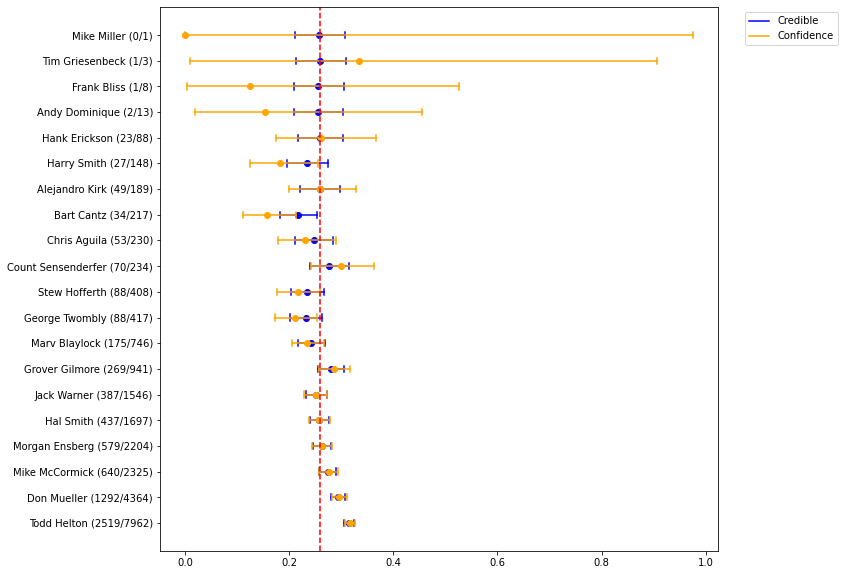

In [35]:
vertical_line_width=0.25

plt.figure(figsize=(10,10))
label_added =False
for lower,upper,mean,y,h,ab in zip(sample20['low'],sample20['high'],sample20['estimate'],range(len(sample20)),sample20['H'], sample20['AB']):
    
    top = y - vertical_line_width / 2
    bottom = y + vertical_line_width / 2
    left = lower
    left_ci = sm.stats.proportion_confint(h, ab, method='beta')[0]
    right = upper
    right_ci = sm.stats.proportion_confint(h, ab, method='beta')[1]
    if not label_added:
        plt.plot([left, right], [y, y], color='blue', label='Credible')
        plt.plot([left, left], [bottom, top], color='blue')
        plt.plot([right, right], [bottom, top], color='blue')
        plt.plot(mean, y,'o', color='blue')
        plt.plot([left_ci, right_ci], [y, y], color='orange', label='Confidence')
        plt.plot([left_ci, left_ci], [bottom, top], color='orange')
        plt.plot([right_ci, right_ci], [bottom, top], color='orange')
        plt.plot(h/ab, y,'o', color='orange')
        label_added = True
    else:
        plt.plot([left, right], [y, y], color='blue')
        plt.plot([left, left], [bottom, top], color='blue')
        plt.plot([right, right], [bottom, top], color='blue')
        plt.plot(mean, y,'o', color='blue')
        
        plt.plot([left_ci, right_ci], [y, y], color='orange')
        plt.plot([left_ci, left_ci], [bottom, top], color='orange')
        plt.plot([right_ci, right_ci], [bottom, top], color='orange')
        plt.plot(h/ab, y,'o', color='orange')
    
plt.yticks(range(len(sample20)),list(sample20['name']+' ('+sample20['H'].astype('str')+'/'+sample20['AB'].astype('str')+')'))
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.axvline(mu, color='red', linestyle='--')
plt.show()